# 20N Newsgroup

In [1]:
import warnings
warnings.simplefilter('ignore')
import os, nltk, re
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords
from gensim import corpora, models, similarities
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
characters_to_remove = '!()#@~,."><*=-'
pattern = "[" + characters_to_remove + "]"
p = PorterStemmer()
tokenizer = nltk.RegexpTokenizer(r'\w+')
freq_to_remove = 11

In [3]:
def process(p, tokenizer, text):
    """ Applies standard pre-processing to given text.
    
    Args:
        p (gensim.parsing.porter.PorterStemmer): stemmer object.
        tokenizer (nltk.tokenize.regexp.RegexpTokenizer): tokenizr object.
        text (str): text to preprocess.
    
    Returns:
        list: preprocessed text.
    
    """
    # Converts to lowercase
    doc_nor = text.lower()
    
    # Removes stopwords
    doc_sw = remove_stopwords(doc_nor)
    
    # Stems text
    doc_stem = p.stem_sentence(doc_sw)
    
    # Lemmatizes text
    # TODO: Lemmatizer
    
    # Returns preprocessed text
    return tokenizer.tokenize(doc_stem)

In [4]:
categories = os.listdir('./data/20news')
category_index = {}
for i, cat in enumerate(categories):
    d = {cat: i}
    category_index.update(d)
print(category_index)

{'comp.sys.ibm.pc.hardware': 0, 'soc.religion.christian': 1, 'sci.med': 2, 'talk.politics.misc': 3, 'talk.religion.misc': 4, 'comp.os.ms-windows.misc': 5, 'sci.crypt': 6, 'alt.atheism': 7, 'sci.space': 8, 'talk.politics.guns': 9, 'talk.politics.mideast': 10, 'comp.graphics': 11, 'rec.motorcycles': 12, 'comp.windows.x': 13, 'comp.sys.mac.hardware': 14, 'rec.autos': 15, 'rec.sport.hockey': 16, 'rec.sport.baseball': 17, 'sci.electronics': 18, 'misc.forsale': 19}


In [5]:
corpus = []
listed_text = []
listed_categories = []
for category in categories:
    files = os.listdir('./data/20news/' + category)
    for file in files:
        doc = open('./data/20news/' + category + '/' + file, encoding = 'ISO-8859-1',mode='r')
        text = re.sub(pattern, "", doc.read().replace('\n', '').replace('  ', ''))
        corpus.append(text)
        listed_text.append(process(p, tokenizer, text))
        listed_categories.append(category)
        doc.close()

In [6]:
dictionary = corpora.Dictionary(listed_text)
dictionary.filter_extremes(no_below=freq_to_remove)
dictionary.save('./resources/20news/vocab20news.dict')
doc_corpus = []
for doc in listed_text:
    doc_corpus.append(dictionary.doc2bow(doc))
print('Dictionary length: ' + str(len(dictionary)))

Dictionary length: 15254


In [7]:
bool_bow = np.zeros((len(doc_corpus), len(dictionary) + 1), dtype=np.int8)
bow = np.zeros((len(doc_corpus), len(dictionary) + 1), dtype=np.int8)
for index, doc in enumerate(doc_corpus):
    bool_bow[index, -1] = category_index[listed_categories[index]]
    bow[index, -1] = category_index[listed_categories[index]]
    for item in doc:
        bool_bow[index, item[0]] = 1
        bow[index, item[0]] = item[1]
np.save('./resources/20news/bool_bow_matrix.npy', bool_bow)
np.save('./resources/20news/bow_matrix.npy', bow)

In [8]:
vectorizer = TfidfVectorizer(min_df=freq_to_remove)
X = vectorizer.fit_transform(corpus)
np.save('./resources/20news/tfidf_matrix.npy', X.toarray())

In [9]:
def train_validate_classifier(classifier, X, y, k):
    """ Trains k-fold cross validation for classifier
    Args:
        classifier (str): Model to be trained
        X (numpy.ndarray): Training matrix
        y (numpy.ndarray): Tags
        k (int): Number of cross validation cases
        
    Return:
        (dict): Dictionary with resulting scores
    """
    if classifier == 'NB':
        clf = GaussianNB()
    elif classifier == 'LR':
        clf = LogisticRegression(max_iter=300)
    cv_results = cross_validate(clf, 
                      X_train, y_train, 
                      scoring=['precision_macro', 'recall_macro'], 
                      cv=k, n_jobs=1, 
                      return_estimator=True)
    return cv_results

In [10]:
X_train = np.load('./resources/20news/tfidf_matrix.npy')
y_label = np.load('./resources/20news/bool_bow_matrix.npy')[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_label, train_size=0.7)
cv_results_tfidf = {}
print('Started training')
cv_results_tfidf_nb = train_validate_classifier('NB', X_train, y_train, 10)
cv_results_tfidf.update(cv_results_tfidf_nb)
print('Trained NB')
cv_results_tfidf_lr = train_validate_classifier('LR', X_train, y_train, 10)
cv_results_tfidf.update(cv_results_tfidf_lr)
print('Trained LR')
cv_results_tfidf['model'] = 'tfidf'

Started training
Trained NB
Trained LR


In [11]:
X_train = np.load('./resources/20news/bool_bow_matrix.npy')
y_label = X_train[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X_train[:,:-1], X_train[:,-1], train_size=0.7)
cv_results_bb = {}
print('Started training')
cv_results_bb_nb = train_validate_classifier('NB', X_train, y_train, 10)
cv_results_bb.update(cv_results_bb_nb)
print('Trained NB')
cv_results_bb_lr = train_validate_classifier('LR', X_train, y_train, 10)
cv_results_bb.update(cv_results_bb_lr)
print('Trained LR')
cv_results_bb['model'] = 'boolen bow'

Started training
Trained NB
Trained LR


In [12]:
X_train = np.load('./resources/20news/bow_matrix.npy')
X_train, X_test, y_train, y_test = train_test_split(X_train[:,:-1], X_train[:,-1], train_size=0.7)
cv_results_b = {}
print('Started training')
cv_results_b_nb = train_validate_classifier('NB', X_train, y_train, 10)
cv_results_b.update(cv_results_b_nb)
print('Trained NB')
cv_results_b_lr = train_validate_classifier('LR', X_train, y_train, 10)
cv_results_b.update(cv_results_b_lr)
print('Trained LR')
cv_results_b['model'] = 'bow'

Started training
Trained NB
Trained LR


In [76]:
cv_results_bb_lr['estimator_name'] = 'LR'
cv_results_b_lr['estimator_name'] = 'LR'
cv_results_tfidf_lr['estimator_name'] = 'LR'

In [79]:
cv_results = {}
results = pd.concat([pd.DataFrame(data = cv_results_tfidf_lr), pd.DataFrame(data=cv_results_bb_lr), 
                     pd.DataFrame(data=cv_results_b_lr), pd.DataFrame(data=cv_results_bb_nb), 
                     pd.DataFrame(data=cv_results_b_nb),pd.DataFrame(data=cv_results_tfidf_nb)])

In [80]:
results.sort_values(by='test_precision_macro', ascending=False)

,fit_time,score_time,estimator,test_precision_macro,test_recall_macro,estimator_name,model
5,150.345433,0.099817,LogisticRegression(max_iter=300),0.883543,0.871450,LR,tfidf
3,165.397913,0.098249,LogisticRegression(max_iter=300),0.879025,0.866246,LR,tfidf
5,96.534223,0.122783,LogisticRegression(max_iter=300),0.875916,0.868790,LR,boolen bow
9,152.834799,0.095716,LogisticRegression(max_iter=300),0.875724,0.865286,LR,tfidf
8,158.406578,0.080034,LogisticRegression(max_iter=300),0.875628,0.863395,LR,tfidf
9,305.432642,0.088904,LogisticRegression(max_iter=300),0.873827,0.870131,LR,bow
6,143.154512,0.093436,LogisticRegression(max_iter=300),0.873645,0.861123,LR,tfidf
4,101.236158,0.115497,LogisticRegression(max_iter=300),0.873019,0.865461,LR,boolen bow
4,149.132680,0.077299,LogisticRegression(max_iter=300),0.872748,0.861001,LR,tfidf
2,156.321905,0.096235,LogisticRegression(max_iter=300),0.871569,0.865169,LR,tfidf


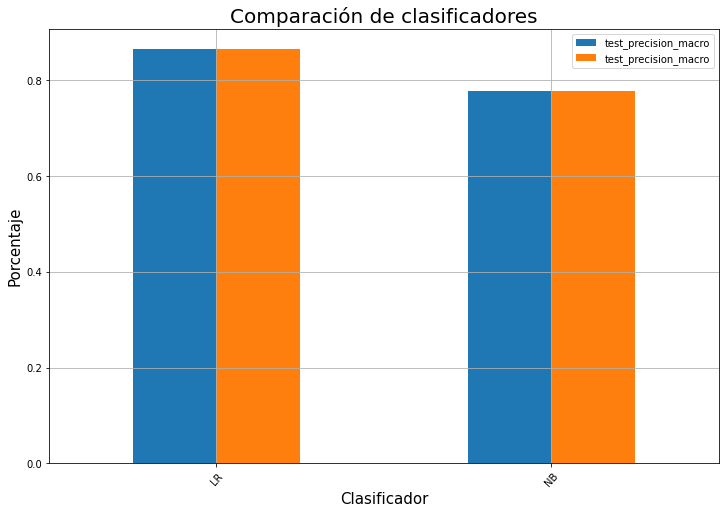

In [82]:
import matplotlib.pyplot as plt
results[['test_precision_macro','test_precision_macro', 'estimator_name']].groupby('estimator_name').mean().plot.bar(figsize=(12,8), rot=48)
plt.title('Comparación de clasificadores', fontsize=20)
plt.xlabel('Clasificador', fontsize=15)
plt.ylabel('Porcentaje', fontsize=15)
plt.grid()
plt.savefig('./results/20news_classifier_comparison.png')

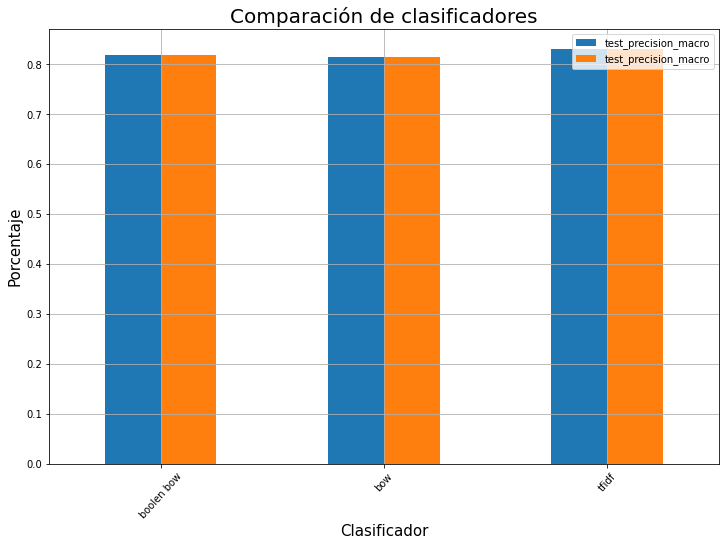

In [83]:
results[['test_precision_macro','test_precision_macro', 'model']].groupby('model').mean().plot.bar(figsize=(12,8), rot=48)
plt.title('Comparación de clasificadores', fontsize=20)
plt.xlabel('Clasificador', fontsize=15)
plt.ylabel('Porcentaje', fontsize=15)
plt.grid()
plt.savefig('./results/20news_classifier_comparison.png')